# Attention Mechanism & Transformers

&copy; 李浩东 3190104890@zju.edu.cn

- Queries, Keys, and Values
- Attention Pooling by Similarity
- Attention Scoring Functions
- The Bahdanau Attention Mechanism
- Multi-Head Attention
- Self-Attention and Positional Encoding
- The Transformer Architecture
- Transformers for Vision


## Queries, Keys, and Values

- So far all the networks we reviewed crucially relied on the input being of a well-defined size. For instance, the images in ImageNet are of size $224\times 224$ pixels and CNNs are specifically tuned to this size. Even in natural language processing the input size for RNNs is well defined and fixed.
- This approach can lead to significant problems when the input is truly of varying size with varying information content, such as text transformation. In particular, for long sequences it becomes quite difficult to keep track of everything that has already been generated or even viewed by the network.

- Compare this to databases. In their simplest form they are collections of keys ($k$) and values ($v$).
- For instance, our database $\mathcal{D}$ might consist of tuples {(“Zhang”, “Aston”), (“Lipton”, “Zachary”), (“Li”, “Mu”), (“Smola”, “Alex”), (“Hu”, “Rachel”), (“Werness”, “Brent”)} with the last name being the key and the first name being the value. 
- We can operate on $\mathcal{D}$, for instance with the exact query ($q$) for “Li” which would return the value “Mu”. In case (“Li”, “Mu”) was not a record in $\mathcal{D}$, there would be no valid answer. 
- If we also allowed for approximate matches, we would retrieve (“Lipton”, “Zachary”) instead.

- We can design queries $q$ that operate on ($k$,$v$) pairs in such a manner as to be valid regardless of the database size.
- The same query can receive different answers, according to the contents of the database.
- The “code” being executed to operate on a large state space (the database) can be quite simple (e.g., exact match, approximate match, top-$k$).
- There is no need to compress or simplify the database to make the operations effective.

- Clearly we would not have introduced a simple database here if it wasn't for the purpose of explaining deep learning. Indeed, this leads to one of the most exciting concepts arguably introduced in deep learning in the past decade: the attention mechanism (Bahdanau et al., 2014).
- For now, simply consider the following: denote by $\mathcal{D} \stackrel{\mathrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$ a database of $m$ tuples of *keys* and *values*. Moreover, denote by $\mathbf{q}$ as *query*. Then we can define the *attention* over $\mathcal{D}$ as

$$\mathrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\mathrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,$$

[Bahdanau et al., 2014] Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.

$$\mathrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\mathrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,$$

- where $\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathbb{R}$ ($i = 1, \ldots, m$) are scalar attention weights. The operation itself is typically referred to as *attention pooling*. 
- The name *attention* derives from the fact that the operation pays particular attention to the terms for which the weight $\alpha$ is significant (i.e., large). As such, the attention over $\mathcal{D}$ generates a linear combination of values contained in the database. In fact, this contains the above example as a special case where all but one weight is zero. We have a number of special cases:
    * The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ are nonnegative. In this case the output of the attention mechanism is contained in the convex cone spanned by the values $\mathbf{v}_i$. 
    * The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ form a convex combination, i.e., $\sum_i \alpha(\mathbf{q}, \mathbf{k}_i) = 1$ and $\alpha(\mathbf{q}, \mathbf{k}_i) \geq 0$ for all $i$. This is the most common setting in deep learning. 
    * Exactly one of the weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ is $1$, while all others are $0$. This is akin to a traditional database query. 
    * All weights are equal, i.e., $\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{1}{m}$ for all $i$. This amounts to averaging across the entire database, also called average pooling in deep learning.


- A common strategy to ensure that the weights sum up to $1$ is to normalize them via 

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{{\sum_j} \alpha(\mathbf{q}, \mathbf{k}_j)}.$$

- In particular, to ensure that the weights are also nonnegative, one can resort to exponentiation. This means that we can now pick *any* function  $a(\mathbf{q}, \mathbf{k})$ and then apply the softmax operation used for multinomial models to it via

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}. $$

- This operation is readily available in all deep learning frameworks. It is differentiable and its gradient never vanishes, all of which are desirable properties in a model. Note though, the attention mechanism introduced above is not the only option. For instance, we can design a non-differentiable attention model that can be trained using reinforcement learning methods (Mnih et al., 2014).
- As one would expect, training such a model is quite complex. Consequently the bulk of modern attention research follows the framework outlined below.

![qkv.svg](./images/8/qkv.svg)

[Mnih et al., 2014] Mnih, V., Heess, N., Graves, A., & others. (2014). Recurrent models of visual attention. Advances in neural information processing systems (pp. 2204–2212).

- What is quite remarkable is that the actual “code” to execute on the set of keys and values, namely the query, can be quite concise, even though the space to operate on is significant. 
- This is a desirable property for a network layer as it does not require too many parameters to learn. Just as convenient is the fact that attention can operate on arbitrarily large databases without the need to change the way the attention pooling operation is performed.
- As a quick sanity check let's visualize the identity matrix, representing a case where the attention weight is one only when the query and the key are the same.

In [1]:
import torch
from d2l import torch as d2l

#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(10, 10),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

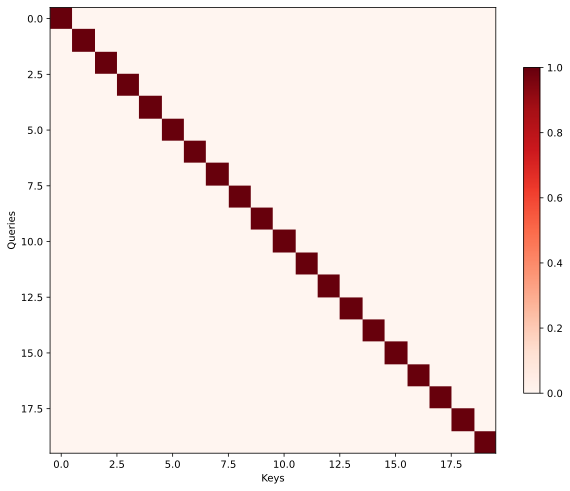

In [2]:
attention_weights = torch.eye(20).reshape((1, 1, 20, 20))
# (number of rows for display, number of columns for display, number of queries, number of keys)
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## Attention Pooling by Similarity

- Now that we introduced the primary components of the attention mechanism, let's use them in a rather classical setting, namely regression and classification via kernel density estimation (Nadaraya, 1964, Watson, 1964).
- At their core, Nadaraya-Watson estimators rely on some similarity kernel $\alpha(\mathbf{q}, \mathbf{k})$ relating queries $\mathbf{q}$ to keys $\mathbf{k}$. Some common kernels are

$$\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \mathrm{Gaussian} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \text{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \mathrm{Boxcar} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \mathrm{Epanechikov}
\end{aligned}
$$



[Nadaraya, 1964] Nadaraya, E. A. (1964). On estimating regression. Theory of Probability & Its Applications, 9(1), 141–142.

[Watson, 1964] Watson, G. S. (1964). Smooth regression analysis. Sankhyā: The Indian Journal of Statistics, Series A, pp. 359–372.

- All of the kernels are heuristic and can be tuned. For instance, we can adjust the width, not only on a global basis but even on a per-coordinate basis. 
- Regardless, all of them lead to the following equation for regression and classification alike:

$$f(\mathbf{q}) = \sum_i \mathbf{v}_i \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}.$$

- In the case of a (scalar) regression with observations $(\mathbf{x}_i, y_i)$ for features and labels respectively, $\mathbf{v}_i = y_i$ are scalars, $\mathbf{k}_i = \mathbf{x}_i$ are vectors, and the query $\mathbf{q}$ denotes the new location where $f$ should be evaluated. In the case of (multiclass) classification, we use one-hot-encoding of $y_i$ to obtain $\mathbf{v}_i$. One of the convenient properties of this estimator is that it requires no training. 
- Even more so, if we suitably narrow the kernel with increasing amounts of data, the approach is consistent, i.e., it will converge to some statistically optimal solution. Let's start by inspecting some kernels.


- All the kernels $\alpha(\mathbf{k}, \mathbf{q})$ defined in this section are *translation and rotation invariant*, 
- that is, if we shift and rotate $\mathbf{k}$ and $\mathbf{q}$ in the same manner, the value of $\alpha$ remains unchanged. For simplicity we thus pick scalar arguments $k, q \in \mathbb{R}$ and pick the key $k = 0$ as the origin. This yields:

In [55]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import pandas as pd
import math

d2l.use_svg_display()

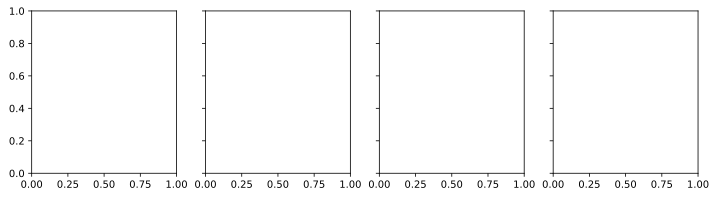

In [4]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

In [5]:
kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

- Different kernels correspond to different notions of range and smoothness. For instance, the boxcar kernel only attends to observations within a distance of $1$ (or some otherwise defined hyperparameter) and does so indiscriminately. 
- To see Nadaraya-Watson estimation in action, let's define some training data. In the following we use the dependency

$$y_i = 2\sin(x_i) + x_i + \epsilon,$$

- where $\epsilon$ is drawn from a normal distribution with zero mean and unit variance. We draw 40 training examples.

In [6]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

- Now that we have data and kernels, all we need is a function that computes the kernel regression estimates. 
- Note that we also want to obtain the relative kernel weights in order to perform some minor diagnostics. 
- Hence we first compute the kernel between all training features (covariates) `x_train` and all validation features `x_val`. This yields a matrix, which we subsequently normalize. 
- When multiplied with the training labels `y_train` we obtain the estimates.
- Let each validation feature be a query, and each training feature-label pair be a key-value pair. As a result, the normalized relative kernel weights (`attention_w` below) are the *attention weights*.

In [7]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

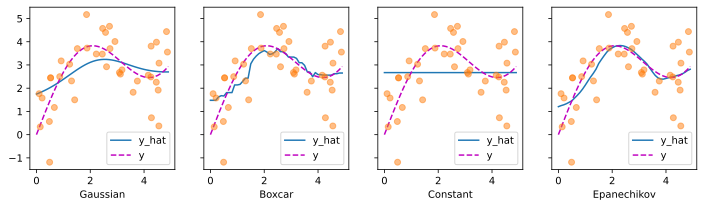

In [8]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

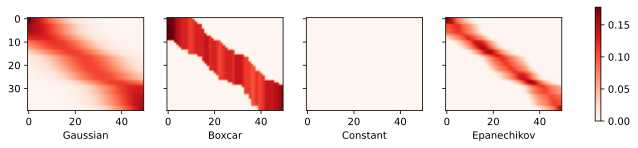

In [9]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

- We could replace the Gaussian kernel with one of a different width. That is, we could use $\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)$ where $\sigma^2$ determines the width of the kernel. Let's see whether this affects the outcomes.


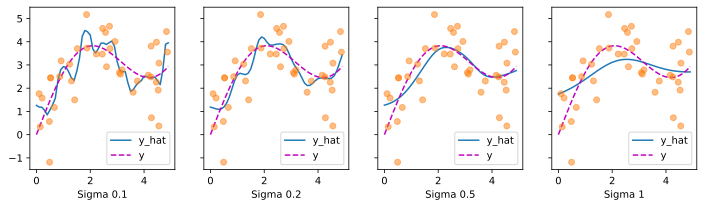

In [10]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

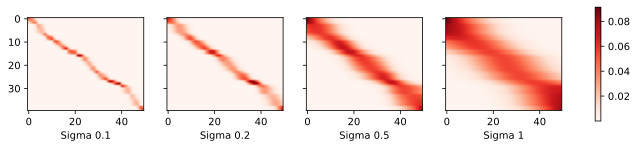

In [11]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

## Attention Scoring Functions

- In last section, we used a number of different distance-based kernels, including a Gaussian kernel to model interactions between queries and keys. As it turns out, distance functions are slightly more expensive to compute than inner products. As such, with the softmax operation to ensure nonnegative attention weights, much of the work has gone into *attention scoring functions* $a$.
- Computing the output of attention pooling as a weighted average of values, where weights are computed with the attention scoring function $a$ and the softmax operation.

![attention-output.svg](./images/8/attention-output.svg)


### Dot Product Attention

- Let's review the attention function (without exponentiation) from the Gaussian kernel for a moment:

$$
\begin{aligned}
a(\mathbf{q}, \mathbf{k}_i) & = -\frac{1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2  \\
& = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2  -\frac{1}{2} \|\mathbf{q}\|^2.
\end{aligned}
$$

- First, note that the last term depends on $\mathbf{q}$ only. As such it is identical for all $(\mathbf{q}, \mathbf{k}_i)$ pairs. Normalizing the attention weights to $1$ ensures that this term disappears entirely. 
- Second, note that both batch and layer normalization (to be discussed later) lead to activations that have well-bounded, and often constant norms $\|\mathbf{k}_i\| \approx \mathrm{const}$. This is the case, for instance, whenever the keys $\mathbf{k}_i$ were generated by a layer norm. As such, we can drop it from the definition of $a$ without any major change in the outcome. 

- Last, we need to keep the order of magnitude of the arguments in the exponential function under control. 
- Assume that all the elements of the query $\mathbf{q} \in \mathbb{R}^d$ and the key $\mathbf{k}_i \in \mathbb{R}^d$ are independent and identically drawn random variables with zero mean and unit variance. The dot product between both vectors has zero mean and a variance of $d$. 
- To ensure that the variance of the dot product still remains one regardless of vector length, we use the *scaled dot-product attention* scoring function. That is, we rescale the dot-product by $1/\sqrt{d}$. We thus arrive at the first commonly used attention function that is used, e.g., in Transformers (Vaswani et al., 2017):

$$ a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}.$$

[Vaswani et al., 2017] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems (pp. 5998–6008).

- Note that attention weights $\alpha$ still need normalizing. We can simplify this further by using the softmax operation:

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.$$

- As it turns out, all popular attention mechanisms use the softmax, hence we will limit ourselves to that in the remainder of this chapter.

### Convenience Functions

- We need a few functions to make the attention mechanism efficient to deploy. This includes tools to deal with strings of variable lengths (common for natural language processing) and tools for efficient evaluation on minibatches (batch matrix multiplication).

#### Masked Softmax Operation

- One of the most popular applications of the attention mechanism is to sequence models. Hence we need to be able to deal with sequences of different lengths. In some cases, such sequences may end up in the same minibatch, necessitating padding with dummy tokens for shorter sequences. These special tokens do not carry meaning. For instance, assume that we have the following three sentences:

```
Dive  into  Deep    Learning
Learn to    code    <blank>
Hello world <blank> <blank>
```

- Since we do not want blanks in our attention model we simply need to limit $\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ to $\sum_{i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ for however long $l \leq n$ the actual sentence is. Since it is such a common problem, it has a name: the *masked softmax operation*. 
- Let's implement it. Actually, the implementation cheats ever so slightly by setting the values to zero $\mathbf{v}_i = 0$ for $i > l$. Moreover, it sets the attention weights to a large negative number, such as $-10^{6}$ in order to make their contribution to gradients and values vanish in practice. This is done since linear algebra kernels and operators are heavily optimized for GPUs and it is faster to be slightly wasteful in computation rather than to have code with conditional (if then else) statements.

In [12]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4570, 0.5430, 0.0000, 0.0000],
         [0.5812, 0.4188, 0.0000, 0.0000]],

        [[0.4259, 0.3494, 0.2247, 0.0000],
         [0.2888, 0.4671, 0.2440, 0.0000]]])

In [14]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2353, 0.3831, 0.3815, 0.0000]],

        [[0.4010, 0.5990, 0.0000, 0.0000],
         [0.4075, 0.1668, 0.1818, 0.2439]]])

#### Batch Matrix Multiplication

- Another commonly used operation is to multiply batches of matrices with another. This comes in handy when we have minibatches of queries, keys, and values. More specifically, assume that 

$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b} \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c} 
$$

- Then the batch matrix multiplication (BMM) computes the element-wise product

$$\mathrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$

- Let's see this in action in a deep learning framework.


In [15]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(Q, K).shape == torch.Size([2, 3, 6])

True

### Scaled Dot-Product Attention

- Let's return to the dot-product attention. In general, it requires that both the query and the key have the same vector length, say $d$, even though this can be addressed easily by replacing $\mathbf{q}^\top \mathbf{k}$ with $\mathbf{q}^\top \mathbf{M} \mathbf{k}$ where $\mathbf{M}$ is a suitably chosen matrix to translate between both spaces. For now assume that the dimensions match. 
- In practice, we often think in minibatches for efficiency, such as computing attention for $n$ queries and $m$ key-value pairs, where queries and keys are of length $d$ and values are of length $v$. The scaled dot-product attention of queries $\mathbf Q\in\mathbb R^{n\times d}$, keys $\mathbf K\in\mathbb R^{m\times d}$, and values $\mathbf V\in\mathbb R^{m\times v}$ thus can be written as:

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$

In [16]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

- To illustrate how the `DotProductAttention` class works, we use the same keys, values, and valid lengths from the earlier toy example for additive attention. 
- For the purpose of our example we assume that we have a minibatch size of $2$, a total of $10$ keys and values, and that the dimensionality of the values is $4$. Lastly, we assume that the valid length per observation is $2$ and $6$ respectively. Given that, we expect the output to be a $2 \times 1 \times 4$ tensor, i.e., one row per example of the minibatch.

In [17]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens).shape == torch.Size([2, 1, 4])

True

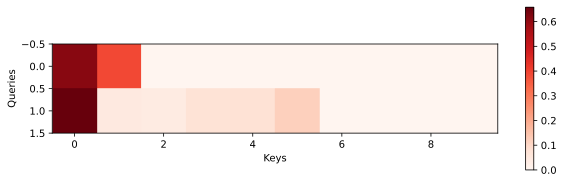

In [18]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries', figsize=(10, 5))

### Additive Attention

- When queries $\mathbf{q}$ and keys $\mathbf{k}$ are vectors of different dimensionalities, we can either use a matrix to address the mismatch via $\mathbf{q}^\top \mathbf{M} \mathbf{k}$, or we can use additive attention as the scoring function. Another benefit is that, as its name indicates, the attention is additive. This can lead to some minor computational savings. 
- Given a query $\mathbf{q} \in \mathbb{R}^q$ and a key $\mathbf{k} \in \mathbb{R}^k$, the *additive attention* scoring function (Bahdanau et al., 2014) is given by

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

- where $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, and $\mathbf w_v\in\mathbb R^{h}$ are the learnable parameters. This term is then fed into a softmax to ensure both nonnegativity and normalization. An equivalent interpretation is that the query and key are concatenated and fed into an MLP with a single hidden layer. Using $\tanh$ as the activation function and disabling bias terms, we implement additive attention as follows:

[Bahdanau et al., 2014] Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.

In [19]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

- Let's see how `AdditiveAttention` works. In our toy example we pick queries, keys and values of size $(2, 1, 20)$, $(2, 10, 2)$ and $(2, 10, 4)$, respectively. 
- This is identical to our choice for `DotProductAttention`, except that now the queries are $20$-dimensional. Likewise, we pick $(2, 6)$ as the valid lengths for the sequences in the minibatch.

In [20]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens).shape == torch.Size([2, 1, 4])

/home/haodong/Applications/Miniconda/Miniconda/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


True

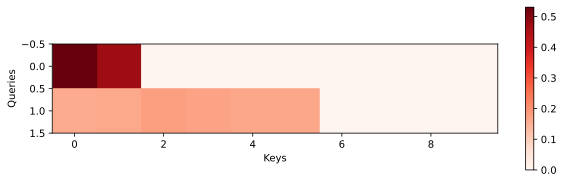

In [21]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries', figsize=(10, 5))

## The Bahdanau Attention Mechanism

- When we encountered machine translation in Section 8-3, we designed an encoder-decoder architecture for sequence to sequence (seq2seq) learning based on two RNNs. 
- Specifically, the RNN encoder transforms a variable-length sequence into a fixed-shape context variable. Then, the RNN decoder generates the output (target) sequence token by token based on the generated tokens and the context variable.
- Conventionally, in an RNN all relevant information about a source sequence is translated into some internal fixed-dimensional state representation by the encoder. It is this very state that is used by the decoder as the complete and exclusive source of information to generate the translated sequence. 
- In other words, the seq2seq mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

![seq2seq-state.svg](./images/8/seq2seq-state.svg)


- While this is quite reasonable for short sequences, it is clear that it is infeasible for long sequences, such as a book chapter or even just a very long sentence. After all, after a while there will simply not be enough "space" in the intermediate representation to store all that is important in the source sequence. Consequently the decoder will fail to translate long and complex sentences. 
- One of the first to encounter was (Graves, 2013) when they tried to design an RNN to generate handwritten text. Since the source text has arbitrary length they designed a differentiable attention model to align text characters with the much longer pen trace, where the alignment moves only in one direction.
- Inspired by the idea of learning to align, (Bahdanau et al. 2014) proposed a differentiable attention model *without* the unidirectional alignment limitation. When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to parts of the input sequence that are deemed relevant to the current prediction. 
- This is then used to update the current state before generating the next token. While quite innocuous in its description, this *Bahdanau attention mechanism* has arguably turned into one of the most influential ideas of the past decade in deep learning, giving rise to Transformers (Vaswani et al., 2017) and many related new architectures.

[Graves, 2013] Graves, A. (2013). Generating sequences with recurrent neural networks. arXiv preprint arXiv:1308.0850.

[Bahdanau et al., 2014] Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.

[Vaswani et al., 2017] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems (pp. 5998–6008).

### Model

- We follow the notation introduced by the seq2seq architecture.
- The key idea is that instead of keeping the state, i.e., the context variable $\mathbf{c}$ summarizing the source sentence as fixed, we dynamically update it, as a function of both the original text (encoder hidden states $\mathbf{h}_{t}$) and the text that was already generated (decoder hidden states $\mathbf{s}_{t'-1}$). This yields $\mathbf{c}_{t'}$, which is updated after any decoding time step $t'$. Suppose that the input sequence is of length $T$. In this case the context variable is the output of attention pooling:

$$\mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_{t}) \mathbf{h}_{t}.$$

- We used $\mathbf{s}_{t' - 1}$ as the query, and $\mathbf{h}_{t}$ as both the key and the value. Note that $\mathbf{c}_{t'}$ is then used to generate the state $\mathbf{s}_{t'}$ and to generate a new token. In particular, the attention weight $\alpha$ is computed using the additive attention scoring function.

- This RNN encoder-decoder architecture using attention is depicted below. Note that later this model was modified such as to include the already generated tokens in the decoder as further context (i.e., the attention sum does stop at $T$ but rather it proceeds up to $t'-1$). For instance, see (Chan et al., 2015) for a description of this strategy, as applied to speech recognition.

![seq2seq-details-attention.svg](./images/8/seq2seq-details-attention.svg)


[Chan et al., 2015] Chan, W., Jaitly, N., Le, Q. V., & Vinyals, O. (2015). Listen, attend and spell. arXiv preprint arXiv:1508.01211.

### Defining the Decoder with Attention

- We need to implement the RNN decoder in the `Seq2SeqAttentionDecoder` class.
- The state of the decoder is initialized with
    - (i) the hidden states of the last layer of the encoder at all time steps, used as keys and values for attention;
    - (ii) the hidden state of the encoder at all layers at the final time step. This serves to initialize the hidden state of the decoder;
and 
    - (iii) the valid length of the encoder, to exclude the padding tokens in attention pooling.
- At each decoding time step, the hidden state of the last layer of the decoder, obtained at the previous time step, is used as the query of the attention mechanism.
- Both the output of the attention mechanism and the input embedding are concatenated to serve as the input of the RNN decoder.

In [22]:
class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [23]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [24]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)

print(output.shape == torch.Size([batch_size, num_steps, vocab_size]))
print(state[0].shape == torch.Size([batch_size, num_steps, num_hiddens]))
print(state[1].shape == torch.Size([num_layers, batch_size, num_hiddens]))

True
True
True


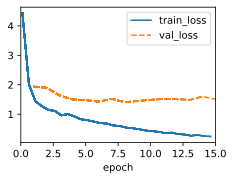

In [25]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.4
encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = d2l.Trainer(max_epochs=15, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [26]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['<unk>', '.'], bleu,0.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


- Let’s visualize the attention weights when translating the last English sentence. We see that each query assigns non-uniform weights over key-value pairs. It shows that at each decoding step, different parts of the input sequences are selectively aggregated in the attention pooling.

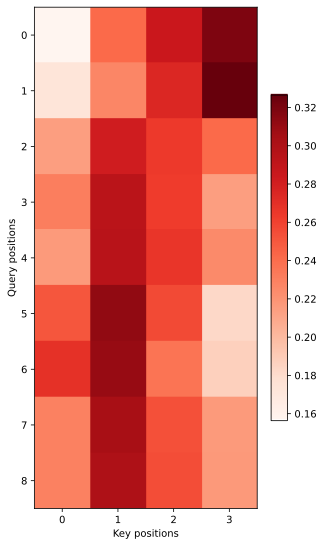

In [27]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions', figsize=(5, 10))

## Multi-Head Attention

- In practice, given the same set of queries, keys, and values we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (e.g., shorter-range vs. longer-range) within a sequence. Thus, it may be beneficial to allow our attention mechanism to jointly use different representation subspaces of queries, keys, and values.
- To this end, instead of performing a single attention pooling, queries, keys, and values can be transformed with $h$ independently learned linear projections. Then these $h$ projected queries, keys, and values are fed into attention pooling in parallel. In the end, $h$ attention pooling outputs are concatenated and transformed with another learned linear projection to produce the final output. This design is called *multi-head attention*, where each of the $h$ attention pooling outputs is a *head* (Vaswani et al., 2017). Using fully connected layers to erform learnable linear transformations.

![multi-head-attention.svg](./images/8/multi-head-attention.svg)

[Vaswani et al., 2017] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems (pp. 5998–6008).

### Model

- Before providing the implementation of multi-head attention, let's formalize this model mathematically.
- Given a query $\mathbf{q} \in \mathbb{R}^{d_q}$, a key $\mathbf{k} \in \mathbb{R}^{d_k}$, and a value $\mathbf{v} \in \mathbb{R}^{d_v}$, each attention head $\mathbf{h}_i$  ($i = 1, \ldots, h$) is computed as

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

- where learnable parameters
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$
and $\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$,
and
$f$ is attention pooling,
such as
additive attention and scaled dot-product attention.
- The multi-head attention output
is another linear transformation via 
learnable parameters
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$
of the concatenation of $h$ heads:

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

- Based on this design, each head may attend
to different parts of the input.
More sophisticated functions 
than the simple weighted average can be expressed.
- 
In our implementation,
we choose the scaled dot-product attention
for each head of the multi-head attention.
To avoid significant growth of computational cost and parameterization cost,
we set $p_q = p_k = p_v = p_o / h$.
Note that $h$ heads can be computed in parallel
if we set the number of outputs 
of linear transformations
for the query, key, and value
to $p_q h = p_k h = p_v h = p_o$.
In the following implementation,
$p_o$ is specified via the argument `num_hiddens`.


In [28]:
class MultiHeadAttention(d2l.Module):  #@save
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

- To allow for parallel computation of multiple heads,
the above `MultiHeadAttention` class uses two transposition methods as defined below.
Specifically,
the `transpose_output` method reverses the operation
of the `transpose_qkv` method.

In [29]:
@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

- Let's test our implemented `MultiHeadAttention` class
using a toy example where keys and values are the same.
As a result,
the shape of the multi-head attention output
is (`batch_size`, `num_queries`, `num_hiddens`).

In [30]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens)) # this `num_hiddens` is unnecessary
Y = torch.ones((batch_size, num_kvpairs, num_hiddens)) # this `num_hiddens` is unnecessary, either
attention(X, Y, Y, valid_lens).shape == torch.Size([batch_size, num_queries, num_hiddens])

True

## Self-Attention and Positional Encoding

- In deep learning, we often use CNNs or RNNs to encode sequences.
Now with attention mechanisms in mind, 
imagine feeding a sequence of tokens 
into an attention mechanism
such that at each step,
each token has its own query, keys, and values.
- Here, when computing the value of a token's representation at the next layer,
the token can attend (via its query vector) to each other token 
(matching based on their key vectors).
Using the full set of query-key compatibility scores,
we can compute, for each token, a representation
by building the appropriate weighted sum
over the other tokens. 
Because each token is attending to each other token
(unlike the case where decoder steps attend to encoder steps),
such architectures are typically described as *self-attention* models (Lin et al., 2017, Vaswani et al., 2017), 
and elsewhere described as *intra-attention* model (Cheng et al., 2016, Parikh et al., 2016, Paulus et al., 2017).

### Self-Attention

- Given a sequence of input tokens
$\mathbf{x}_1, \ldots, \mathbf{x}_n$ where any $\mathbf{x}_i \in \mathbb{R}^d$ ($1 \leq i \leq n$),
its self-attention outputs
a sequence of the same length
$\mathbf{y}_1, \ldots, \mathbf{y}_n$,
where

$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$$

- according to the definition of attention pooling.
Using multi-head attention,
the following code snippet
computes the self-attention of a tensor
with shape (batch size, number of time steps or sequence length in tokens, $d$).
The output tensor has the same shape.


In [31]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape == torch.Size([batch_size, num_queries, num_hiddens])

True

- Let's
compare architectures for mapping
a sequence of $n$ tokens
to another sequence of equal length,
where each input or output token is represented by
a $d$-dimensional vector.
Specifically,
we will consider CNNs, RNNs, and self-attention.
- We will compare their
computational complexity, 
sequential operations,
and maximum path lengths.
Note that sequential operations prevent parallel computation,
while a shorter path between
any combination of sequence positions
makes it easier to learn long-range dependencies 
within the sequence.

![cnn-rnn-self-attention.svg](./images/8/cnn-rnn-self-attention.svg)

- Consider a convolutional layer whose kernel size is $k$.
We will provide more details about sequence processing
using CNNs in later chapters.
For now, we only need to know that
since the sequence length is $n$,
the numbers of input and output channels are both $d$,
the computational complexity of the convolutional layer is $\mathcal{O}(knd^2)$.
As CNNs are hierarchical,
so there are $\mathcal{O}(1)$ sequential operations
and the maximum path length is $\mathcal{O}(\log_k(n))$.

- When updating the hidden state of RNNs,
multiplication of the $d \times d$ weight matrix
and the $d$-dimensional hidden state has 
a computational complexity of $\mathcal{O}(d^2)$.
Since the sequence length is $n$,
the computational complexity of the recurrent layer
is $\mathcal{O}(nd^2)$.
There are $\mathcal{O}(n)$ sequential operations
that cannot be parallelized
and the maximum path length is also $\mathcal{O}(n)$.



- In self-attention,
the queries, keys, and values 
are all $n \times d$ matrices.
Consider the scaled dot-product attention,
where a $n \times d$ matrix is multiplied by
a $d \times n$ matrix,
then the output $n \times n$ matrix is multiplied
by a $n \times d$ matrix.
As a result,
the self-attention
has a $\mathcal{O}(n^2d)$ computational complexity.
As each token is directly connected
to any other token via self-attention.
Therefore,
computation can be parallel with $\mathcal{O}(1)$ sequential operations
and the maximum path length is also $\mathcal{O}(1)$.

- All in all,
both CNNs and self-attention enjoy parallel computation
and self-attention has the shortest maximum path length.
However, the quadratic computational complexity with respect to the sequence length
makes self-attention prohibitively slow for very long sequences.

### Positional Encoding

- Unlike RNNs, which recurrently process
tokens of a sequence one by one,
self-attention ditches
sequential operations in favor of 
parallel computation.
Note, however, that self-attention by itself
does not preserve the order of the sequence. 
What do we do if it really matters 
that the model knows in which order
the input sequence arrived?

- The dominant approach for preserving 
information about the order of tokens
is to represent this to the model 
as an additional input associated 
with each token. 
These inputs are called *positional encodings*.
and they can either be learned or fixed a priori.
We now describe a simple scheme for fixed positional encodings
based on sine and cosine functions

- Suppose that the input representation 
$\mathbf{X} \in \mathbb{R}^{n \times d}$ 
contains the $d$-dimensional embeddings 
for $n$ tokens of a sequence.
The positional encoding outputs
$\mathbf{X} + \mathbf{P}$
using a positional embedding matrix 
$\mathbf{P} \in \mathbb{R}^{n \times d}$ of the same shape,
whose element on the $i^\mathrm{th}$ row 
and the $(2j)^\mathrm{th}$
or the $(2j + 1)^\mathrm{th}$ column is

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$

- At first glance,
this trigonometric-function
design looks weird.
Before explanations of this design,
let's first implement it in the following `PositionalEncoding` class.

In [32]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

- In the positional embedding matrix $\mathbf{P}$,
rows correspond to positions within a sequence
and columns represent different positional encoding dimensions.
In the example below,
we can see that
the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$
columns of the positional embedding matrix 
have a higher frequency than 
the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$
columns.
The offset between 
the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$ (same for the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$) columns
is due to the alternation of sine and cosine functions.


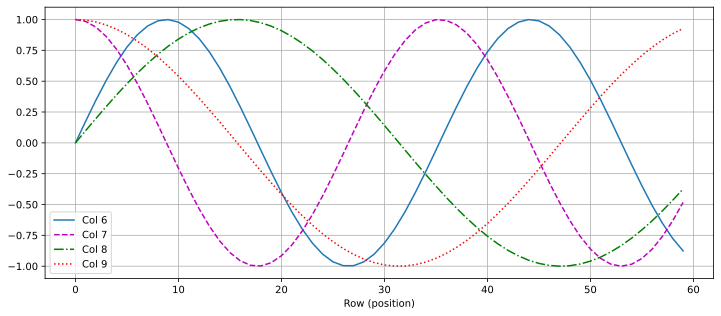

In [33]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(12, 5), legend=["Col %d" % d for d in torch.arange(6, 10)])

#### Absolute Positional Information

- To see how the monotonically decreased frequency
along the encoding dimension relates to absolute positional information,
let's print out the binary representations of $0, 1, \ldots, 7$.
As we can see, the lowest bit, the second-lowest bit, 
and the third-lowest bit alternate on every number, 
every two numbers, and every four numbers, respectively.



In [34]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


- In binary representations, a higher bit 
has a lower frequency than a lower bit.
Similarly, as demonstrated in the heat map below,
the positional encoding decreases
frequencies along the encoding dimension
by using trigonometric functions.
Since the outputs are float numbers,
such continuous representations
are more space-efficient
than binary representations.

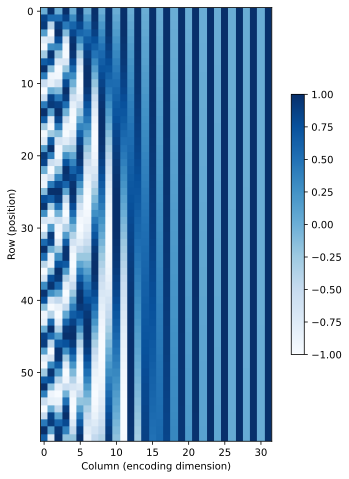

In [35]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(7, 8), cmap='Blues')

#### Relative Positional Information

- Besides capturing absolute positional information,
the above positional encoding
also allows
a model to easily learn to attend by relative positions.
This is because
for any fixed position offset $\delta$,
the positional encoding at position $i + \delta$
can be represented by a linear projection
of that at position $i$.


- This projection can be explained
mathematically.
Denoting
$\omega_j = 1/10000^{2j/d}$,
any pair of $(p_{i, 2j}, p_{i, 2j+1})$ 
in positional encoding
can 
be linearly projected to $(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$
for any fixed offset $\delta$:

$$\begin{aligned}
&\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}\\
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}$$

- where the $2\times 2$ projection matrix does not depend on any position index $i$.


## The Transformer Architecture

- Unlike earlier self-attention models that still rely on RNNs for input representations (Cheng et al., 2016, Lin et al., 2017, Paulus et al., 2017), the Transformer model is solely based on attention mechanisms without any convolutional or recurrent layer (Vaswani et al., 2017). 
- Though originally proposed for sequence to sequence learning on text data, Transformers have been pervasive in a wide range of modern deep learning applications, such as in areas of language, vision, speech, and reinforcement learning.


### Model

- As an instance of the encoder-decoder architecture, the overall architecture of the Transformer is presented in figure below. As we can see, the Transformer is composed of an encoder and a decoder. Different from Bahdanau attention for sequence to sequence learning, the input (source) and output (target) sequence embeddings are added with positional encoding before being fed into the encoder and the decoder that stack modules based on self-attention.

![transformer.svg](./images/8/transformer.svg)


- On a high level,
the Transformer encoder is a stack of multiple identical layers,
where each layer
has two sublayers (either is denoted as $\mathrm{sublayer}$).
- The first
is a multi-head self-attention pooling
and the second is a positionwise feed-forward network.
- Specifically,
in the encoder self-attention,
queries, keys, and values are all from the
outputs of the previous encoder layer.
- Inspired by the ResNet,
a residual connection is employed
around both sublayers.
- In the Transformer,
for any input $\mathbf{x} \in \mathbb{R}^d$ at any position of the sequence,
we require that $\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ so that
the residual connection $\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ is feasible.
This addition from the residual connection is immediately
followed by layer normalization.
As a result, the Transformer encoder outputs a $d$-dimensional vector representation
for each position of the input sequence.



- The Transformer decoder is also a stack of multiple identical layers
with residual connections and layer normalizations.
Besides the two sublayers described in
the encoder, the decoder inserts
a third sublayer, known as
the encoder-decoder attention,
between these two.
- In the encoder-decoder attention,
queries are from the
outputs of the previous decoder layer,
and the keys and values are
from the Transformer encoder outputs.
- In the decoder self-attention,
queries, keys, and values are all from the
outputs of the previous decoder layer.
However, each position in the decoder is
allowed to only attend to all positions in the decoder
up to that position.
- This *masked* attention
preserves the auto-regressive property,
ensuring that the prediction only depends
on those output tokens that have been generated.

### Positionwise Feed-Forward Networks

- The positionwise feed-forward network transforms
the representation at all the sequence positions
using the same MLP.
- This is why we call it *positionwise*.
In the implementation below,
the input `X` with shape
(batch size, number of time steps or sequence length in tokens,
number of hidden units or feature dimension)
will be transformed by a two-layer MLP into
an output tensor of shape
(batch size, number of time steps, `ffn_num_outputs`).

In [36]:
class PositionWiseFFN(nn.Module):  #@save
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

- The following example shows that the innermost dimension of a tensor changes to the number of outputs in the positionwise feed-forward network. Since the same MLP transforms at all the positions, when the inputs at all these positions are the same, their outputs are also identical.

In [37]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

/home/haodong/Applications/Miniconda/Miniconda/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[-0.5664,  0.7427, -0.0157, -0.3584, -0.6111,  0.4703, -0.6927, -0.0024],
        [-0.5664,  0.7427, -0.0157, -0.3584, -0.6111,  0.4703, -0.6927, -0.0024],
        [-0.5664,  0.7427, -0.0157, -0.3584, -0.6111,  0.4703, -0.6927, -0.0024]],
       grad_fn=<SelectBackward0>)

### Residual Connection and Layer Normalization

In [38]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


- Now we can implement the `AddNorm` class using a residual connection followed by layer normalization. Dropout is also applied for regularization.

In [39]:
class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [40]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
add_norm(torch.ones(shape), torch.ones(shape)).shape == torch.Size(shape)

True

### Encoder

In [41]:
class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [42]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape == X.shape

True

- In the following Transformer encoder implementation, we stack num_blks instances of the above `TransformerEncoderBlock` classes.

In [43]:
class TransformerEncoder(d2l.Encoder):  #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [44]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape == (2, 100, 24)

True

### Decoder

In [45]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [47]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape == X.shape

True

- Now we construct the entire Transformer decoder
composed of `num_blks` instances of `TransformerDecoderBlock`.

In [48]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

### Training

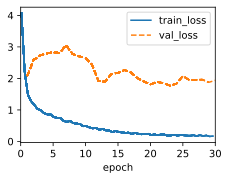

In [49]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [50]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


- Let’s visualize the Transformer attention weights when translating the last English sentence into French. The shape of the encoder self-attention weights is (number of encoder layers, number of attention heads, num_steps or number of queries, num_steps or number of key-value pairs).

In [51]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
enc_attention_weights.shape == (num_blks, num_heads, data.num_steps, data.num_steps)

True

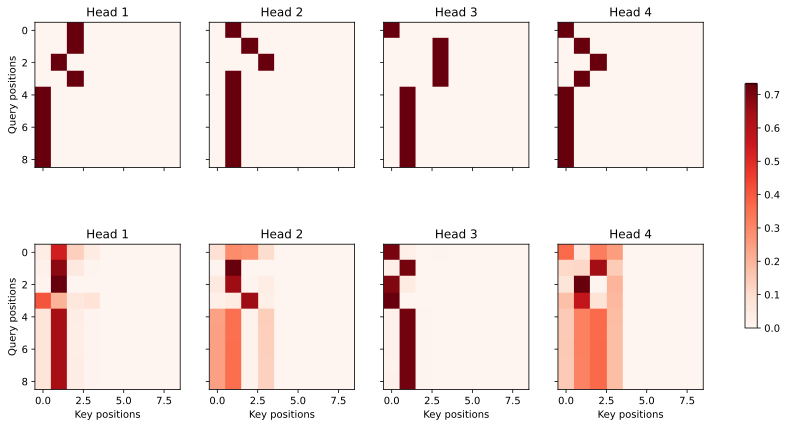

In [53]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(15, 7.5))

- Now visualize both the decoder self-attention weights and the encoder-decoder attention weights.

In [56]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

dec_self_attention_weights.shape == (num_blks, num_heads, data.num_steps, data.num_steps)
dec_inter_attention_weights.shape == (num_blks, num_heads, data.num_steps, data.num_steps)

True

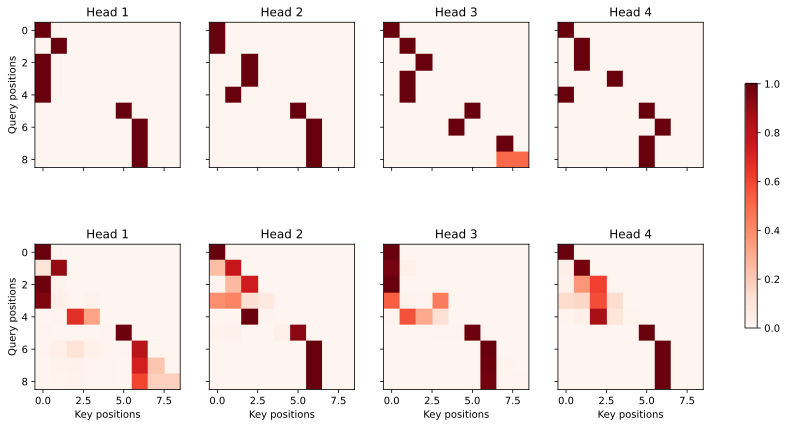

In [58]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(15, 7.5))

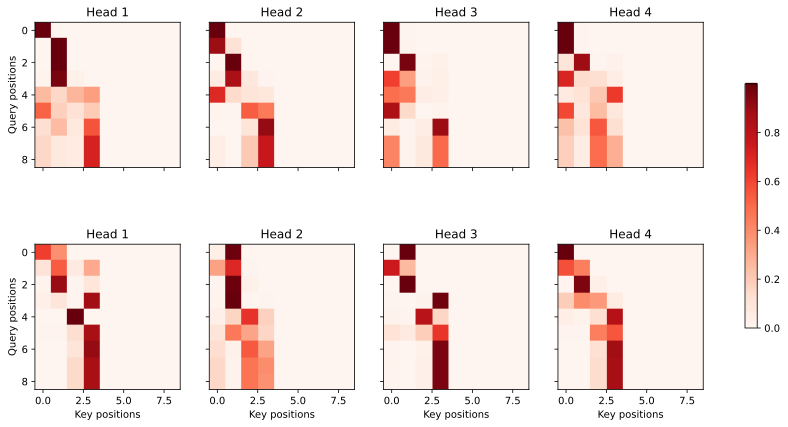

In [60]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(15, 7.5))

## Transformers for Vision

- Naturally, researchers started to wonder
if it might be possible to do better
by adapting Transformer models to image data.
This question sparked immense interest
in the computer vision community.
Recently, Ramachandran et al. (2019) proposed a scheme for replacing convolution with self-attention. However, its use of specialized patterns in attention makes it hard to scale up models on hardware accelerators. Then, Cordonnier et al. (2020) proved 
that self-attention can learn to behave similarly to convolution. 
Empirically, $2 \times 2$ patches were taken from images as inputs, 
but the small patch size makes the model 
only applicable to image data with low resolutions.

- Without specific constraints on patch size, *vision Transformers* (ViTs)
extract patches from images
and feed them into a Transformer encoder
to obtain a global representation,
which will finally be transformed for classification (Dosovitskiy et al., 2021).
Notably, Transformers show better scalability than CNNs:
when training larger models on larger datasets,
vision Transformers outperform ResNets by a significant margin. 
Similar to the landscape of network architecture design in natural language processing,
Transformers also became a game-changer in computer vision.

[Ramachandran et al., 2019] Ramachandran, P., Parmar, N., Vaswani, A., Bello, I., Levskaya, A., & Shlens, J. (2019). Stand-alone self-attention in vision models. Advances in Neural Information Processing Systems, 32.

[Cordonnier et al., 2020] Cordonnier, J.-B., Loukas, A., & Jaggi, M. (2020). On the relationship between self-attention and convolutional layers. International Conference on Learning Representations.

[Dosovitskiy et al., 2021] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., … others. (2021). An image is worth 16x16 words: transformers for image recognition at scale. International Conference on Learning Representations.

### Model

- THe figure below depicts the model architecture of vision Transformers. This architecture consists of a stem that patchifies images, a body based on the multi-layer Transformer encoder, and a head that transforms the global representation into the output label.

![vit.svg](./images/8/vit.svg)


- Consider an input image with height $h$, width $w$,
and $c$ channels.
Specifying the patch height and width both as $p$,
the image is split into a sequence of $m = hw/p^2$ patches,
where each patch is flattened to a vector of length $cp^2$.
In this way, image patches can be treated similarly to tokens in text sequences by Transformer encoders.
- A special “&lt;cls&gt;” (class) token and
the $m$ flattened image patches are linearly projected
into a sequence of $m+1$ vectors,
summed with learnable positional embeddings.
The multi-layer Transformer encoder
transforms $m+1$ input vectors
into the same amount of output vector representations of the same length.
- It works exactly the same way as the original Transformer encoder,
- only differing in the position of normalization.
Since the “&lt;cls&gt;” token attends to all the image patches 
via self-attention,
its representation from the Transformer encoder output
will be further transformed into the output label.


### Patch Embedding

- To implement a vision Transformer, let's start 
with patch embedding. 
Splitting an image into patches 
and linearly projecting these flattened patches
can be simplified as a single convolution operation, 
where both the kernel size and the stride size are set to the patch size.

In [62]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

In [63]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
patch_emb(X).shape == (batch_size, (img_size//patch_size)**2, num_hiddens)

True

### Vision Transformer Encoder

In [64]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

In [65]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [66]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X).shape == X.shape

True

In [67]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

### Training

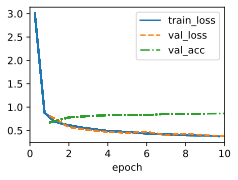

In [68]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)